In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
import re

In [8]:
def create_graph(edges):
    # Create an undirected graph
    graph = nx.Graph()

    # Add edges to the graph
    # You can customize this part based on your specific graph or load it from external data
    graph.add_edges_from(edges)

    return graph

def preparing_edges_to_visualize(file_path):
    edges = []
    with open(file_path, "r") as file:
        for line in file:
            #u, v, sign = map(int, line.strip().split("\t"))
            u, v, sign = map(int, re.split(r'\t|\s+', line.strip()))
            edges.append((u, v, {'sign': sign}))
    return edges


def calculate_delta(graph, upper_bounds):
    delta_values = {}

    # Calculate delta for each vertex
    for node in graph.nodes():
        degree = graph.degree(node)
        upper_bound = upper_bounds[node]
        delta = degree - upper_bound
        delta_values[node] = delta

    return delta_values

def create_bipartite_graph(node, delta, degree, combined_bipartite_edges, graph_dict):

    bipartite_graph = nx.Graph()

    # Add nodes to the first class
    # range starts from node value to node+delta value
    
    delta_node_names = []
    
    for i in range(0, delta):
        if i != 0:
            delta_node_name = str(node) + "." + str(i)
            delta_node_names.append(delta_node_name)
        else:
            delta_node_names.append(node)
    
    bipartite_graph.add_nodes_from(delta_node_names, bipartite=0)


    # Add nodes to the second class
    bipartite_graph.add_nodes_from(graph_dict[str(node)], bipartite=1)

    # Add edges between nodes of opposite classes
    bipartite_graph.add_edges_from([(delta_node, degree_node) for delta_node in delta_node_names for degree_node in graph_dict[str(node)]])
    
    #getting edges from eact subgraphs
    for primary_edge, secondary_edge in bipartite_graph.edges():
        # checking subgraph edges is same as individual node value
        if primary_edge == node:
            # created edges for entire graph 
#             edge = (primary_edge, (str(node) +"->"+ str(secondary_edge)))
            edge = (primary_edge, int(str(node) + str(secondary_edge)))
        else:
            # created edges for entire graph 
#             edge = (primary_edge, (str(node) +"->"+ str(secondary_edge)))
            edge = (primary_edge, int(str(node) + str(secondary_edge)))
            
        #appending edges
        combined_bipartite_edges.append(edge)
        
    return (bipartite_graph, node)


def display_all_bipartite_graphs(bipartite_graphs, n):
    
    plt.figure(figsize=(12, 8))
    
    for i, (bipartite_graph, node) in enumerate(bipartite_graphs):
        plt.subplot(int(len(n)/2), 3, i + 1)
        pos = nx.spring_layout(bipartite_graph)
        nx.draw(bipartite_graph, pos, with_labels=True, font_weight='bold', node_color=['skyblue' if bipartite == 0 else 'lightcoral' for bipartite in nx.get_node_attributes(bipartite_graph, 'bipartite').values()], node_size=500, edgecolors='black', linewidths=1.0)
        plt.title(f"Bipartite Graph for Node {node}")

    plt.tight_layout()
    plt.show()

In [9]:
def read_signed_graph_from_file(file_path):
    graph = {}
    
    unsigned_graph = []
    
    with open(file_path, 'r') as file:
        for line in file:
            source, target, weight = map(int, line.strip().split())
            unsigned_graph.append((source, target))
            
            if source not in graph:
                graph[source] = []
            if target not in graph:
                graph[target] = []
            graph[source].append((target, weight))
            graph[target].append((source, weight))
    return graph, unsigned_graph

def finding_positive_and_negative_neighbours(g):
    
    all_pos_connections = {}
    all_neg_connections = {}
    
    for node in g:
        pos_nei = []
        neg_nei = []
        
        for nei, sign in g[node]:
            if sign == 1:
                pos_nei.append(nei)
            elif sign == -1:
                neg_nei.append(nei)
            
        all_pos_connections[node] = {"neighbour": pos_nei}
        all_neg_connections[node] = {"neighbour": neg_nei}
    
    for node in g:
        all_pos_connections[node]['total_count'] = len(all_pos_connections[node]['neighbour'])
        all_pos_connections[node]['inside_d_count'] = 0
        
        all_neg_connections[node]['total_count'] = len(all_neg_connections[node]['neighbour'])
        all_neg_connections[node]['inside_d_count'] = 0
    
    
    return all_pos_connections, all_neg_connections
            
    
def pos_neg_inside_d_or_not(d, all_positive, all_negative):
    
    all_pos = all_positive
    all_neg = all_negative
    
    b = []
    
    for node in d:
        to_check = [elem for elem in d if elem != node]
        
        for checking_value in to_check:
            if checking_value in all_pos[node]['neighbour']:
                all_pos[node]['total_count'] -= 1
                all_pos[node]['inside_d_count'] += 1
                
                
            elif checking_value in all_neg[node]['neighbour']:
                all_neg[node]['total_count'] -= 1
                all_neg[node]['inside_d_count'] += 1
            
        node_max_neg_count = max(all_neg[node]['total_count'], all_neg[node]['inside_d_count'])
        
        if (all_pos[node]['inside_d_count'] + 1) < node_max_neg_count:
            b.append(node)
    
    return b, all_pos, all_neg


def check_upper_bound(graph, b, all_pos, all_neg):
    upper_bound = {}
    
    for node in graph:
        if node not in b:
            upper_bound[node] = 0
        else:
            b1 = all_neg[node]['total_count'] - all_pos[node]['inside_d_count'] - 1
            
            b2 = math.ceil((all_neg[node]['inside_d_count'] - all_pos[node]['inside_d_count'] - 1) / 2)
            
            upper_bound[node] = max(b1, b2)
            
    return upper_bound

def find_max_edge(matching):
    edges = []
    for node, nei in matching:
        if str(node) == str(nei)[::-1]:
            edges.append(( int(str(node)[0]), int(str(nei)[0]) ))
    return set(edges)
    
    
def finding_bipratie_graph_connecting_edges(combined_bipartite_edges):
    connecting = []
    rev_nodes = []

    # Iterate through the list to build mappings
    for node1, node2 in combined_bipartite_edges:
    #     print(node1, node2)
        rev_node = int(str(node2)[::-1])
        edge_set = (node2, rev_node)
        if rev_node not in rev_nodes:
            if edge_set not in connecting:
                connecting.append((node2, rev_node))
                rev_nodes.append(rev_node)
                rev_nodes.append(node2)
            
    return connecting
    
    

Graph with Upper Degree Constraints:
[(1, {'upper_bound': 2}), (2, {'upper_bound': 0}), (3, {'upper_bound': 1}), (7, {'upper_bound': 0}), (6, {'upper_bound': 0}), (5, {'upper_bound': 0}), (4, {'upper_bound': 0})]

Delta Values:
{1: 4, 2: 4, 3: 3, 7: 3, 6: 4, 5: 4, 4: 3}


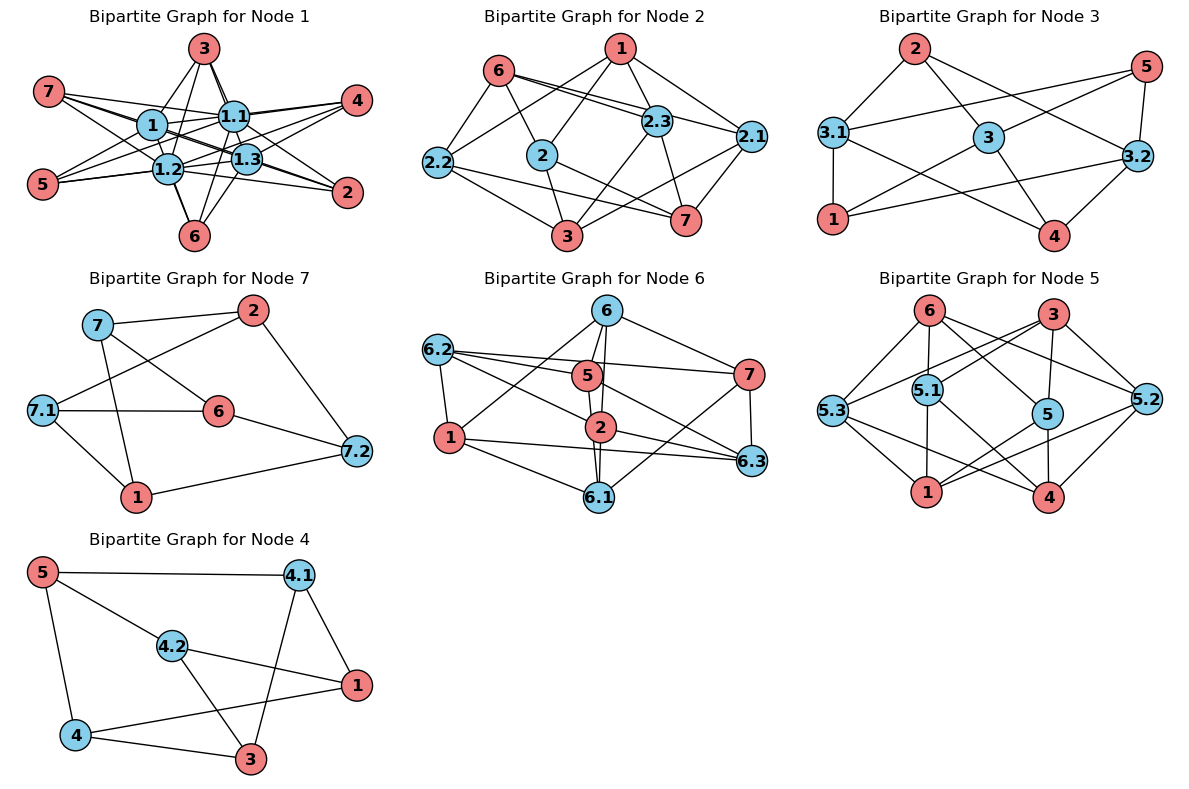

Matching: {(45, 4), ('5.1', 54), ('3.2', 34), ('2.2', 23), ('5.3', 51), ('4.2', 41), (31, 13), (67, 6), ('6.1', 65), ('3.1', 32), ('1.1', 15), ('6.2', 62), ('1.2', 14), ('2.3', 21), ('7.2', 71), ('4.1', 43), ('5.2', 53), (56, 5), (27, 2), (17, 1), ('1.3', 12), (76, 7), ('6.3', 61), (35, 3), ('2.1', 26), ('7.1', 72)}


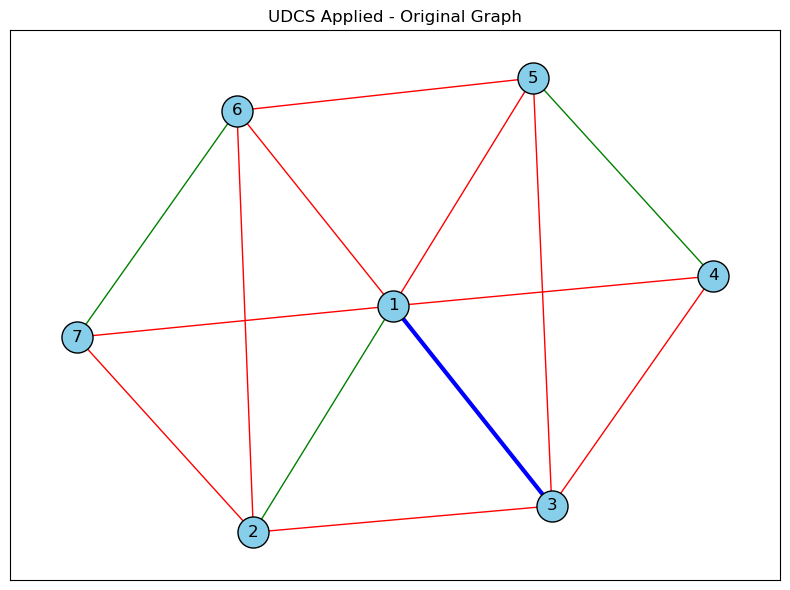

In [11]:
# Create the graph
file_path = r"/Users/mac/Desktop/Desktop/RCS_Signed_Graph/Meeting_4/graph_test_files/test2.txt"

# here graph means signed graph edge set. original_graph means same unsigned graph edge set.
graph, original_graph  = read_signed_graph_from_file(file_path) 

# getting the vertex which has to be check for UDCS from user
d = [1,2,3]

# Find positive and negative edges and store the counts of degrees. 
all_positive, all_negative = finding_positive_and_negative_neighbours(graph)

# Find the B vertex get by checking conditions
b, all_positive_after_check, all_negative_after_check = pos_neg_inside_d_or_not(d, all_positive, all_negative)

# Check the upper boundary for each node and set the values Accordingly based on condition b1 and b2
upper_bounds_dict = check_upper_bound(graph,b,all_positive_after_check, all_negative_after_check)


my_graph = create_graph(original_graph)


# Making dictionary for other purpose
graph_dict = {}

for edge in original_graph:
    graph_dict.setdefault(str(edge[0]), []).append(edge[1])
    graph_dict.setdefault(str(edge[1]), []).append(edge[0])

# Convert values to sets to remove duplicate neighbors
graph_dict = {key: list(set(value)) for key, value in graph_dict.items()}


# Set upper bounds as node attributes
nx.set_node_attributes(my_graph, upper_bounds_dict, 'upper_bound')

# Print the graph with upper degree constraints
print("Graph with Upper Degree Constraints:")
print(my_graph.nodes(data=True))

# Calculate delta values for each vertex
delta_values_dict = calculate_delta(my_graph, upper_bounds_dict)

# Print the delta values for each vertex
print("\nDelta Values:")
print(delta_values_dict)

# list to combine edges from original and sub graphs
combined_bipartite_graph = []


# Create bipartite graphs for each vertex
bipartite_graphs = [create_bipartite_graph(node, 
                                           delta_values_dict[node], 
                                           my_graph.degree(node), 
                                           combined_bipartite_graph,
                                           graph_dict) for node in my_graph.nodes()]

# Display individual bipartite graphs
display_all_bipartite_graphs(bipartite_graphs,  my_graph.nodes())


# Create a dictionary to store same edge connections (eg, [(31, 13), (21, 12)])
connecting_bipartite_edges = finding_bipratie_graph_connecting_edges(combined_bipartite_graph)
# print(connecting_bipartite_edges)

# combining bipartite graphs and connecting_bipartite_egdes 
for edges in connecting_bipartite_edges:
    combined_bipartite_graph.append(edges)



# Display the graph with connected bipartite subgraphs
com_graph = create_graph(combined_bipartite_graph)
# pos_combined = nx.spring_layout(com_graph)


# renamed_graph = nx.relabel_nodes(com_graph, renaming_label)
# pos_combined = nx.spring_layout(renamed_graph)

# org_graph = nx.spring_layout(my_graph)

# sub_graph_edges = []
# delta_list = []

# # for edge in renamed_graph.edges():
# for edge in com_graph.edges():
#     if edge not in my_graph.edges():
#         sub_graph_edges.append(edge)
    
# for node in com_graph.nodes():
#     if isinstance(node, str):
#         delta_list.append(node)

        
# Example usage:
matching = nx.algorithms.matching.max_weight_matching(com_graph, maxcardinality=False)
print("Matching:", matching)
max_matching_edges = find_max_edge(matching)


edges = preparing_edges_to_visualize(file_path)

# Create a signed graph
signed_graph = nx.Graph()
signed_graph.add_edges_from(edges)

pos = nx.spring_layout(signed_graph)
positive_edges = [(u, v) for u, v, data in signed_graph.edges(data=True) if data['sign'] == 1]
negative_edges = [(u, v) for u, v, data in signed_graph.edges(data=True) if data['sign'] == -1]

plt.figure(figsize=(8,6))

nx.draw_networkx_nodes(signed_graph, pos, node_color="skyblue", node_size=500, edgecolors='black', linewidths=1.0)
nx.draw_networkx_edges(signed_graph, pos, edgelist=positive_edges, edge_color='green')
nx.draw_networkx_edges(signed_graph, pos, edgelist=negative_edges, edge_color='red')
nx.draw_networkx_edges(signed_graph, pos, edgelist=max_matching_edges, edge_color='blue', width=3.0)
nx.draw_networkx_labels(signed_graph, pos, font_size=12, font_color='black')

plt.title("UDCS Applied - Original Graph")

# Create subplots
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

# Plot data in the first subplot (axes[0])
# nx.draw_networkx_nodes(com_graph, pos_combined, node_size=1000, node_color= 'lightcoral', edgecolors='black', linewidths=1.0, ax = axes[0])
# nx.draw_networkx_nodes(com_graph, pos_combined, nodelist = my_graph.nodes(),  node_color="skyblue", node_size=1000, edgecolors='black', linewidths=1.0, ax = axes[0])
# nx.draw_networkx_nodes(com_graph, pos_combined, nodelist = delta_list,  node_color="skyblue", node_size=1000, edgecolors='black', linewidths=1.0, ax = axes[0])
# nx.draw_networkx_edges(com_graph, pos_combined, edgelist=sub_graph_edges, edge_color='black', ax = axes[0])
# nx.draw_networkx_labels(com_graph, pos_combined, font_size=12, font_color='black', ax = axes[0])
# nx.draw(renamed_graph, pos_combined, with_labels=True, node_color='skyblue', node_size=1500, font_size=12, font_weight='bold')
# plt.show()
# axes[0].set_title('Combined Bipartited graphs')
# axes[0].legend()

# Plot data in the second subplot (axes[1])
# nx.draw_networkx_nodes(my_graph, org_graph,  node_color="skyblue", node_size=500, edgecolors='black', linewidths=1.0, ax = axes[1])
# nx.draw_networkx_edges(my_graph, org_graph, edge_color='black', ax = axes[1])
# nx.draw_networkx_labels(my_graph, org_graph, font_size=12, font_color='black', ax = axes[1])
# axes[1].set_title('Original graphs')
# axes[1].legend()

plt.tight_layout()

plt.show()
